In [1]:
!pip install brainiak

     |████████████████████████████████| 6.8 MB 24.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.2 MB 22.1 MB/s 
  Using cached pybind11-2.7.1-py2.py3-none-any.whl (200 kB)
     |████████████████████████████████| 59 kB 6.6 MB/s 
     |████████████████████████████████| 2.8 MB 53.2 MB/s 
     |████████████████████████████████| 2.4 MB 30.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.0 MB 59.2 MB/s 
  Created wheel for brainiak: filename=brainiak-0.11-cp37-cp37m-linux_x86_64.whl size=1104117 sha256=367080d67a55fc5a192d213a2be19d43b2c181a66027985ff5ccac0335fceb69
  Stored in directory: /root/.cache/pip/wheels/9b/a1/5f/b7ac0f991e9f859ccf0f58e531343f763da84c218016adee79
  Created wheel for mpi4py

In [2]:
import numpy as np
from scipy import stats
from scipy.io import loadmat
from brainiak.funcalign.srm import SRM
from brainiak.isc import isc
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [12]:
no_TRs_uncropped = 148
no_TRs = 128
no_conds = 4
no_runs = 3

Load data for each subject in the selected ROI.

In [4]:
roi = 'PMC' #'A1', 'MotorCortex', 'PMC'
filepath = 'drive/MyDrive/fMRI_music_data/%s/'%roi
sub = ['03','15','20','23']

In [5]:
# load in the training data as a list of 2D arrays
train_data = []
for s in range(len(sub)):
  train_data.append(np.load(filepath+'sub1%s_runs23.npy'%sub[s]))

# load in test data as a list of 2D arrays
test_data = []
for s in range(len(sub)):
  test_data.append(np.load(filepath+'sub1%s_run1.npy'%sub[s]))

In [6]:
print(train_data[0].shape)
print(test_data[0].shape)

(1573, 1024)
(1573, 512)


In [7]:
# normalize the data by subject
for s in range(len(sub)):
  train_data[s] = stats.zscore(train_data[s],axis=1,ddof=1) 
  # not sure why we need the DOF correction here
  train_data[s] = np.nan_to_num(train_data[s]) # or this...
  
  test_data[s] = stats.zscore(test_data[s],axis=1,ddof=1)
  test_data[s] = np.nan_to_num(test_data[s])

Fit SRM


(code borrowed from BrainIAK tutorial 11 - SRM)

In [8]:
features = 30  # How many features will you fit?
n_iter = 20  # How many iterations of fitting will you perform

# Create the SRM object
srm = SRM(n_iter=n_iter, features=features)

# Fit the SRM data
print('Fitting SRM, may take a minute ...')
srm.fit(train_data)

print('SRM has been fit')

Fitting SRM, may take a minute ...
SRM has been fit


In [19]:
srm_s = srm.transform(test_data)

In [20]:
print(srm_s[0].shape)

(30, 512)


SRM should improve ISC, since it brings out stimulus-related variance.

In [11]:
test_data[0].shape

(1573, 512)

In [17]:
# Reorganize the data for run 1 of each condition (I, 8B, 2B, 1B)
orig_data = np.zeros((len(sub),test_data[0].shape[0],no_TRs,no_conds))
for s in range(len(test_data)):
  orig_data[s,:,:,0] = test_data[s][:,:no_TRs] # Intact
  orig_data[s,:,:,1] = test_data[s][:,no_TRs:no_TRs*2] # 8B
  orig_data[s,:,:,2] = test_data[s][:,no_TRs*2:no_TRs*3] # 2B
  orig_data[s,:,:,3] = test_data[s][:,no_TRs*3:] # 1B
# orig_data is subjects x voxels x TRs
# need it to be TRs x voxels x subjects for ISC computation
orig_data_T = np.transpose(orig_data, axes=(2,1,0,3))
print(orig_data_T.shape)
avg_data = np.average(orig_data_T,axis=1)
avg_data = np.reshape(avg_data,(no_TRs,1,len(sub),no_conds))
print(avg_data.shape)

orig_avg_ISC_vals = []
for c in range(no_conds):
  these_ISC_vals = isc(avg_data[:,:,:,c])
  orig_avg_ISC_vals.append(np.average(these_ISC_vals))
print(orig_avg_ISC_vals)

(128, 1573, 4, 4)
(128, 1, 4, 4)
[0.2260784083114488, 0.18443645222465463, 0.07047131057506562, 0.20456073395262725]


In [25]:
# Reorganize SRM data for run 1 of each condition 
print(srm_s[0].shape)

(30, 512)


In [28]:
srm_data = np.zeros((len(sub),srm_s[0].shape[0],no_TRs,no_conds))
for s in range(len(srm_s)):
  srm_data[s,:,:,0] = srm_s[s][:,:no_TRs] # Intact
  srm_data[s,:,:,1] = srm_s[s][:,no_TRs:no_TRs*2] # 8B
  srm_data[s,:,:,2] = srm_s[s][:,no_TRs*2:no_TRs*3] # 2B
  srm_data[s,:,:,3] = srm_s[s][:,no_TRs*3:] # 1B
# srm_data is subjects x voxels x TRs
# need it to be TRs x voxels x subjects for ISC computation
srm_data_T = np.transpose(srm_data, axes=(2,1,0,3))
print(srm_data_T.shape)
avg_srm_data = np.average(srm_data_T,axis=1)
avg_srm_data = np.reshape(avg_srm_data,(no_TRs,1,len(sub),no_conds))
print(avg_data.shape)

SRM_avg_ISC_vals = []
for c in range(no_conds):
  these_ISC_vals = isc(avg_srm_data[:,:,:,c])
  SRM_avg_ISC_vals.append(np.average(these_ISC_vals))
print(SRM_avg_ISC_vals)

(128, 30, 4, 4)
(128, 1, 4, 4)
[0.11979694894478, 0.2126296052526679, 0.2713453958390831, 0.1866941261929634]


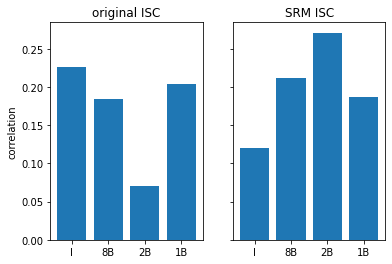

In [41]:
# put it together in a plot
fig,ax = plt.subplots(1,2,sharey=True)
ax[0].bar([1,2,3,4], orig_avg_ISC_vals)
ax[0].set_xticks([1,2,3,4])
ax[0].set_xticklabels(['I','8B','2B','1B'])
ax[0].set_title('original ISC')
ax[0].set_ylabel('correlation')
ax[1].bar([1,2,3,4], SRM_avg_ISC_vals)
ax[1].set_xticks([1,2,3,4])
ax[1].set_xticklabels(['I','8B','2B','1B'])
ax[1].set_title('SRM ISC');

It looks like SRM improves ISC in the 8B and 2B conditions, but makes it worse for the Intact and 1B conditions. Could this be related to the fact that runs 2 and 3 are used for training?